# News Sentiment Analysis - Data Exploration

This notebook provides a comprehensive exploration of the financial news sentiment dataset. We'll analyze the data distribution, text characteristics, and prepare insights for model development.

## Dataset Overview

The dataset contains financial news articles labeled with sentiment (positive, negative, neutral). This analysis will help us understand:
- Data distribution and class balance
- Text length and token statistics
- Vocabulary characteristics
- Sentiment patterns and examples

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from collections import Counter
import re
from wordcloud import WordCloud
from textblob import TextBlob
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


## Data Loading and Initial Inspection

In [5]:
# Load the processed dataset
data_path = Path('../data/financial_news/prepared/processed_all-data.csv')
df = pd.read_csv(data_path)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst few rows:")
df.head()

Dataset shape: (4824, 8)
Columns: ['original_id', 'chunk_id', 'text', 'is_long', 'total_chunks', 'num_tokens', 'cleaning_metrics', 'sentiment']

First few rows:


,original_id,chunk_id,text,is_long,total_chunks,num_tokens,cleaning_metrics,sentiment
0,0,0,According to Gran the company has no plans to ...,False,1,22,"{'urls_removed': 0, 'html_tags_removed': 0, 'e...",neutral
1,1,0,Technopolis plans to develop in stages an area...,False,1,31,"{'urls_removed': 0, 'html_tags_removed': 0, 'e...",neutral
2,2,0,The international electronic industry company ...,False,1,38,"{'urls_removed': 0, 'html_tags_removed': 0, 'e...",negative
3,3,0,With the new production plant the company woul...,False,1,33,"{'urls_removed': 0, 'html_tags_removed': 0, 'e...",positive
4,4,0,According to the company s updated strategy fo...,False,1,40,"{'urls_removed': 0, 'html_tags_removed': 0, 'e...",positive


In [6]:
# Basic dataset information
print("Dataset Info:")
print(f"Total number of articles: {df.shape[0]:,}")
print(f"Unique original articles: {df['original_id'].nunique():,}")
print(f"Articles that were chunked: {df[df['total_chunks'] > 1]['original_id'].nunique():,}")
print(f"Total chunks: {df.shape[0]:,}")

print("\nData Types:")
print(df.dtypes)

print("\nMissing Values:")
print(df.isnull().sum())

Dataset Info:
Total number of articles: 4,824
Unique original articles: 4,824
Articles that were chunked: 0
Total chunks: 4,824

Data Types:
original_id          int64
chunk_id             int64
text                object
is_long               bool
total_chunks         int64
num_tokens           int64
cleaning_metrics    object
sentiment           object
dtype: object

Missing Values:
original_id         0
chunk_id            0
text                0
is_long             0
total_chunks        0
num_tokens          0
cleaning_metrics    0
sentiment           0
dtype: int64


## Sentiment Distribution Analysis

Sentiment Distribution:
Neutral: 2,859 (59.3%)
Positive: 1,362 (28.2%)
Negative: 603 (12.5%)


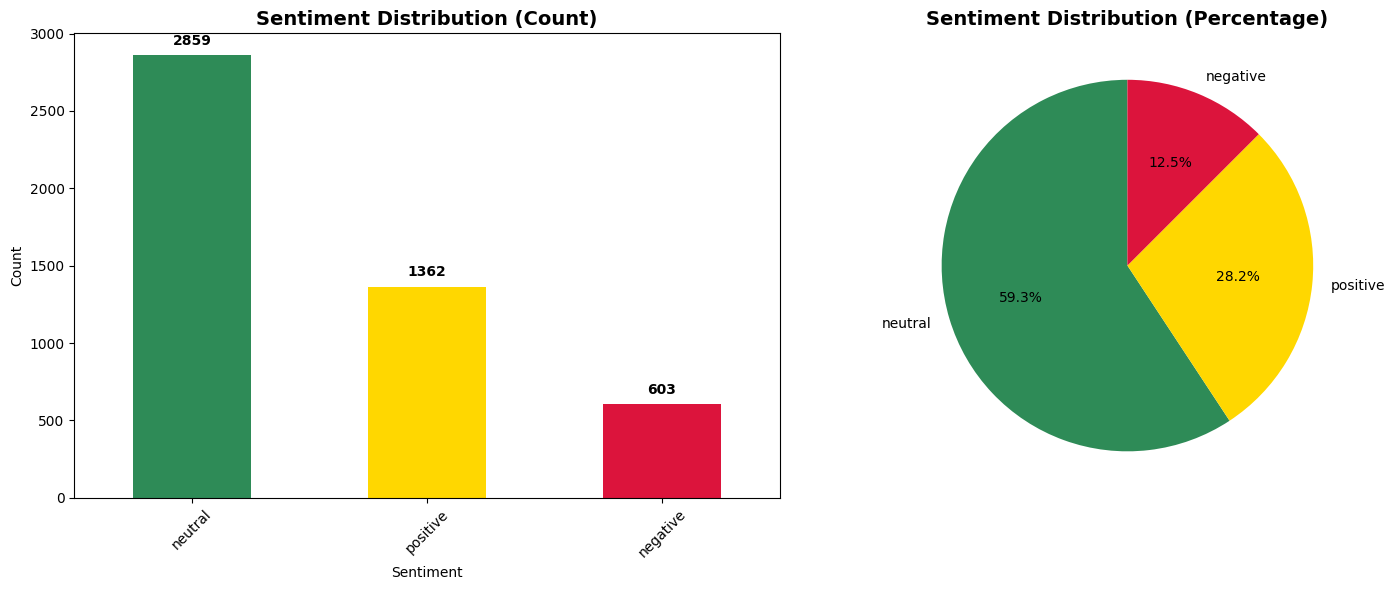

In [7]:
# Sentiment distribution
sentiment_counts = df['sentiment'].value_counts()
sentiment_pct = df['sentiment'].value_counts(normalize=True) * 100

print("Sentiment Distribution:")
for sentiment in sentiment_counts.index:
    count = sentiment_counts[sentiment]
    pct = sentiment_pct[sentiment]
    print(f"{sentiment.capitalize()}: {count:,} ({pct:.1f}%)")

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot
sentiment_counts.plot(kind='bar', ax=ax1, color=['#2E8B57', '#FFD700', '#DC143C'])
ax1.set_title('Sentiment Distribution (Count)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# Add count labels on bars
for i, v in enumerate(sentiment_counts.values):
    ax1.text(i, v + 50, str(v), ha='center', va='bottom', fontweight='bold')

# Pie chart
colors = ['#2E8B57', '#FFD700', '#DC143C']
wedges, texts, autotexts = ax2.pie(sentiment_counts.values, labels=sentiment_counts.index, 
                                   autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('Sentiment Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## Text Length Analysis

In [8]:
# Calculate text statistics
df['text_length'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()

print("Text Length Statistics:")
print("\nCharacter Length:")
print(df['text_length'].describe())
print("\nWord Count:")
print(df['word_count'].describe())
print("\nToken Count (from preprocessing):")
print(df['num_tokens'].describe())

Text Length Statistics:

Character Length:
count    4824.000000
mean      121.951078
std        53.563770
min        19.000000
25%        80.000000
50%       114.000000
75%       156.000000
max       297.000000
Name: text_length, dtype: float64

Word Count:
count    4824.000000
mean       20.566750
std         8.738495
min         4.000000
25%        14.000000
50%        19.000000
75%        26.000000
max        52.000000
Name: word_count, dtype: float64

Token Count (from preprocessing):
count    4824.000000
mean       24.614013
std        11.450977
min         5.000000
25%        16.000000
50%        23.000000
75%        31.000000
max       108.000000
Name: num_tokens, dtype: float64


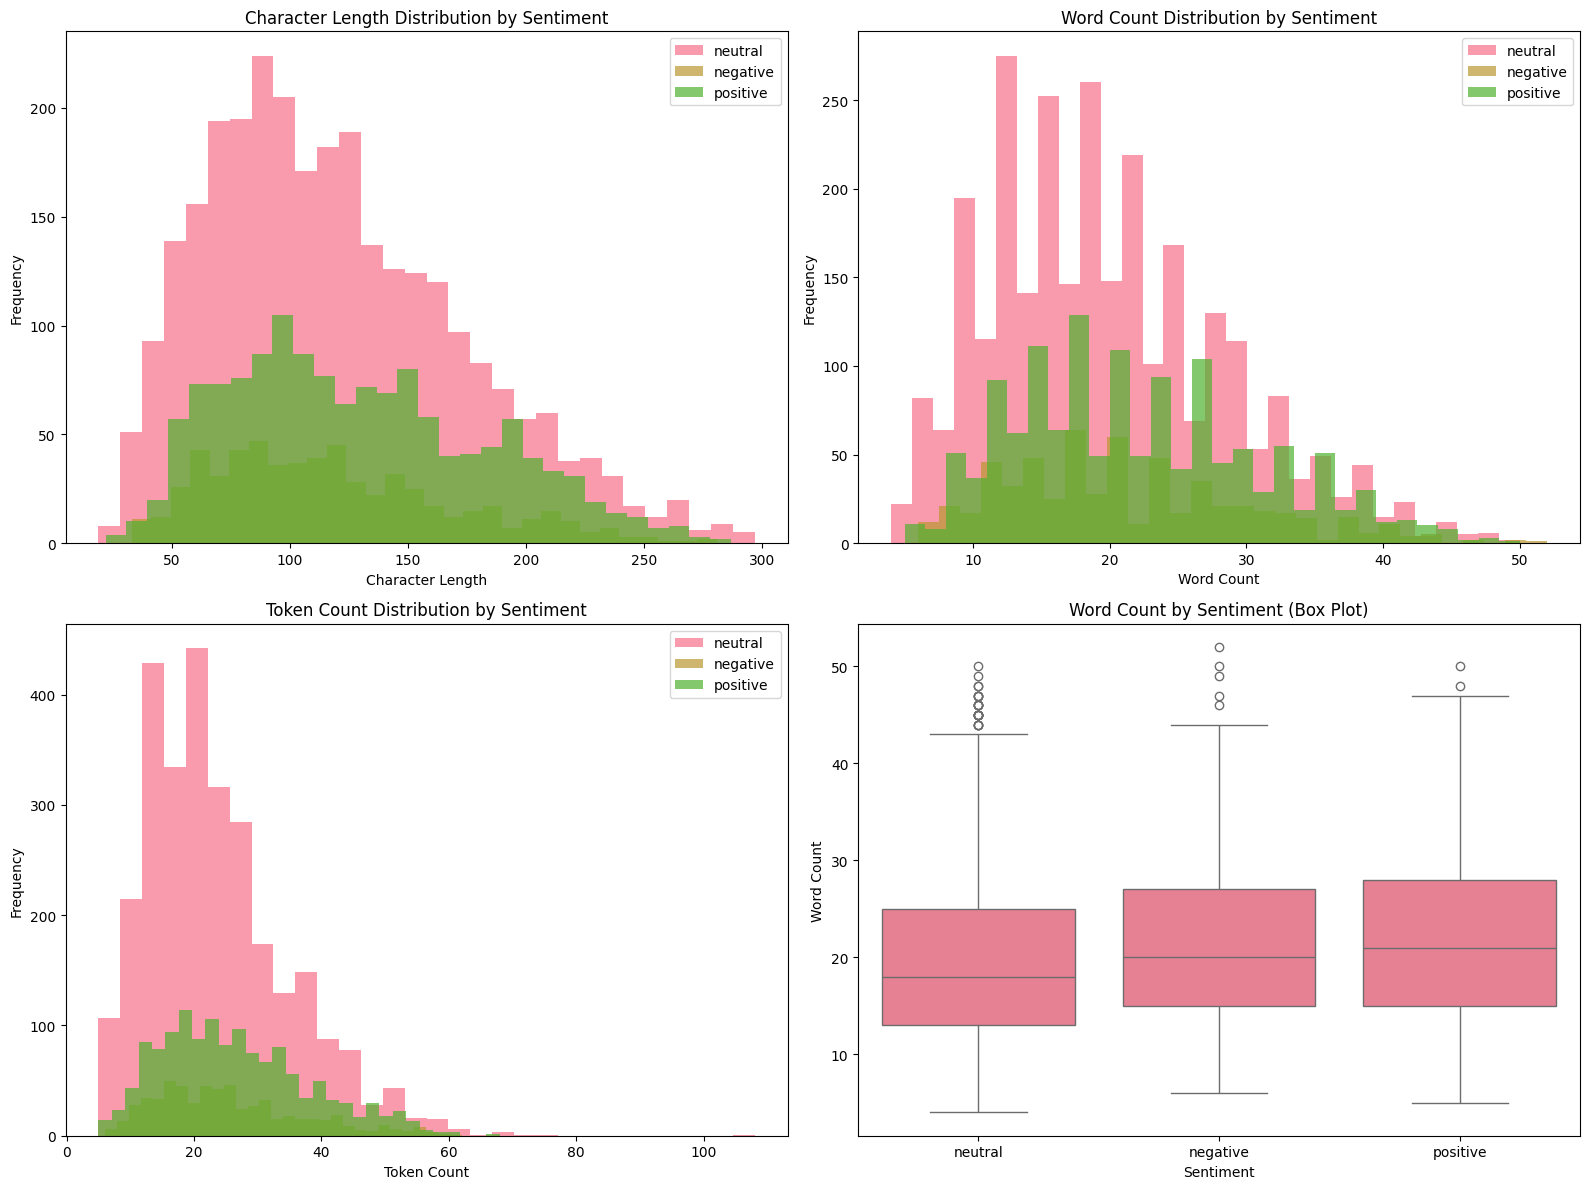

In [10]:
# Text length distribution by sentiment
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Character length distribution
for sentiment in df['sentiment'].unique():
    data = df[df['sentiment'] == sentiment]['text_length']
    axes[0,0].hist(data, alpha=0.7, label=sentiment, bins=30)
axes[0,0].set_title('Character Length Distribution by Sentiment')
axes[0,0].set_xlabel('Character Length')
axes[0,0].set_ylabel('Frequency')
axes[0,0].legend()

# Word count distribution
for sentiment in df['sentiment'].unique():
    data = df[df['sentiment'] == sentiment]['word_count']
    axes[0,1].hist(data, alpha=0.7, label=sentiment, bins=30)
axes[0,1].set_title('Word Count Distribution by Sentiment')
axes[0,1].set_xlabel('Word Count')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend()

# Token count distribution
for sentiment in df['sentiment'].unique():
    data = df[df['sentiment'] == sentiment]['num_tokens']
    axes[1,0].hist(data, alpha=0.7, label=sentiment, bins=30)
axes[1,0].set_title('Token Count Distribution by Sentiment')
axes[1,0].set_xlabel('Token Count')
axes[1,0].set_ylabel('Frequency')
axes[1,0].legend()

# Box plot for word count by sentiment
sns.boxplot(data=df, x='sentiment', y='word_count', ax=axes[1,1])
axes[1,1].set_title('Word Count by Sentiment (Box Plot)')
axes[1,1].set_xlabel('Sentiment')
axes[1,1].set_ylabel('Word Count')

plt.tight_layout()
plt.show()

In [11]:
# Statistical comparison of text lengths by sentiment
print("Text Length Statistics by Sentiment:")
print("\nCharacter Length by Sentiment:")
print(df.groupby('sentiment')['text_length'].describe())
print("\nWord Count by Sentiment:")
print(df.groupby('sentiment')['word_count'].describe())
print("\nToken Count by Sentiment:")
print(df.groupby('sentiment')['num_tokens'].describe())

Text Length Statistics by Sentiment:

Character Length by Sentiment:
            count        mean        std   min   25%    50%     75%    max
sentiment                                                                 
negative    603.0  118.679934  50.651064  33.0  80.0  111.0  148.50  281.0
neutral    2859.0  119.480937  53.817109  19.0  78.0  111.0  154.00  297.0
positive   1362.0  128.584435  53.747941  22.0  86.0  121.5  165.75  287.0

Word Count by Sentiment:
            count       mean       std  min   25%   50%   75%   max
sentiment                                                          
negative    603.0  21.276949  8.875173  6.0  15.0  20.0  27.0  52.0
neutral    2859.0  19.773697  8.546472  4.0  13.0  18.0  25.0  50.0
positive   1362.0  21.917034  8.888716  5.0  15.0  21.0  28.0  50.0

Token Count by Sentiment:
            count       mean        std  min   25%   50%   75%    max
sentiment                                                            
negative    603.0  25.6

## Article Chunking Analysis

Chunking Analysis:
Articles with multiple chunks: 0
Articles marked as long: 0
Maximum chunks per article: 1
Average chunks per article: 1.00


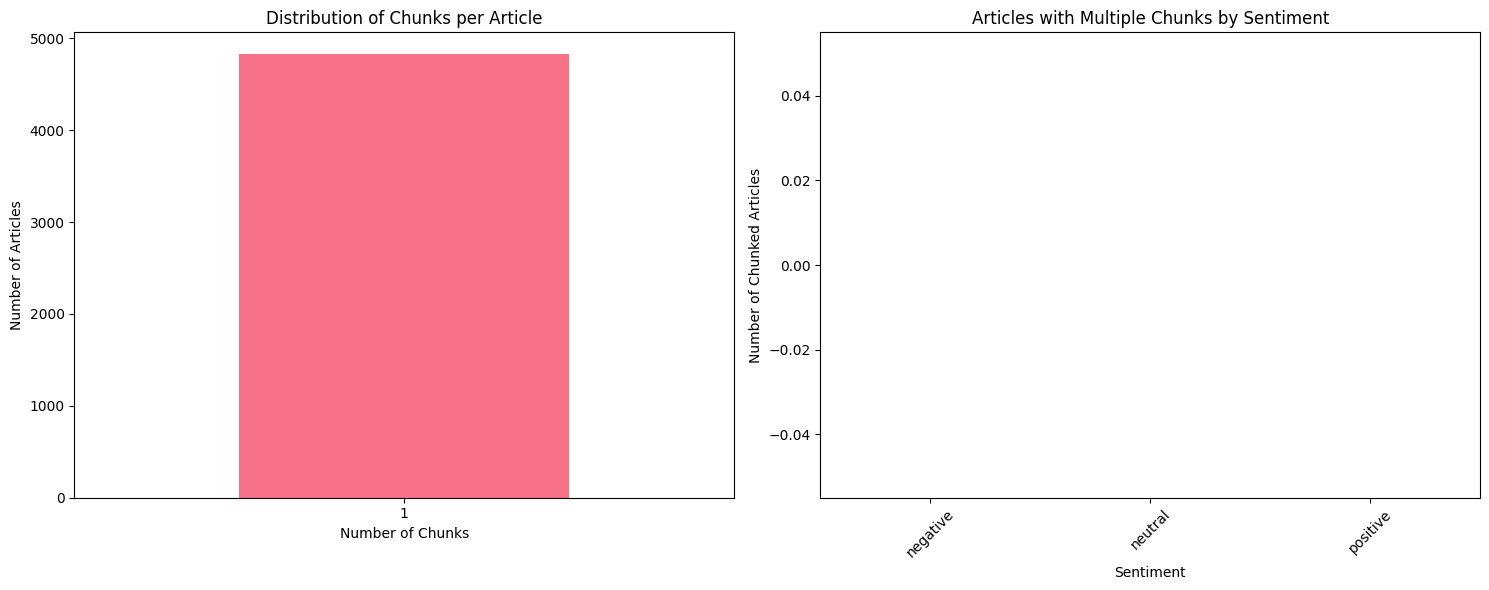

In [12]:
# Analyze chunking patterns
chunk_stats = df.groupby('original_id').agg({
    'total_chunks': 'first',
    'is_long': 'first',
    'sentiment': 'first'
}).reset_index()

print("Chunking Analysis:")
print(f"Articles with multiple chunks: {(chunk_stats['total_chunks'] > 1).sum():,}")
print(f"Articles marked as long: {chunk_stats['is_long'].sum():,}")
print(f"Maximum chunks per article: {chunk_stats['total_chunks'].max()}")
print(f"Average chunks per article: {chunk_stats['total_chunks'].mean():.2f}")

# Chunking distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Distribution of chunks per article
chunk_distribution = chunk_stats['total_chunks'].value_counts().sort_index()
chunk_distribution.plot(kind='bar', ax=ax1)
ax1.set_title('Distribution of Chunks per Article')
ax1.set_xlabel('Number of Chunks')
ax1.set_ylabel('Number of Articles')
ax1.tick_params(axis='x', rotation=0)

# Chunking by sentiment
chunking_by_sentiment = chunk_stats.groupby('sentiment')['total_chunks'].apply(
    lambda x: (x > 1).sum()
)
chunking_by_sentiment.plot(kind='bar', ax=ax2, color=['#DC143C', '#2E8B57', '#FFD700'])
ax2.set_title('Articles with Multiple Chunks by Sentiment')
ax2.set_xlabel('Sentiment')
ax2.set_ylabel('Number of Chunked Articles')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Vocabulary Analysis

In [13]:
# Vocabulary analysis
def get_vocabulary_stats(texts):
    """Calculate vocabulary statistics for a collection of texts."""
    all_words = []
    for text in texts:
        # Simple tokenization - split on whitespace and punctuation
        words = re.findall(r'\b\w+\b', text.lower())
        all_words.extend(words)
    
    word_counts = Counter(all_words)
    return word_counts, len(set(all_words))

# Overall vocabulary
all_word_counts, total_vocab = get_vocabulary_stats(df['text'])
print(f"Total vocabulary size: {total_vocab:,}")
print(f"Total words: {sum(all_word_counts.values()):,}")
print(f"Average word frequency: {sum(all_word_counts.values()) / total_vocab:.2f}")

# Most common words
print("\nTop 20 most common words:")
for word, count in all_word_counts.most_common(20):
    print(f"{word}: {count:,}")

Total vocabulary size: 11,222
Total words: 99,261
Average word frequency: 8.85

Top 20 most common words:
the: 6,064
of: 3,213
in: 2,969
and: 2,593
to: 2,509
a: 1,723
for: 1,151
s: 1,045
eur: 1,016
is: 925
will: 850
company: 848
from: 768
on: 679
its: 646
has: 578
with: 573
by: 558
as: 548
said: 544


Vocabulary size by sentiment:
Neutral: 8,447
Negative: 2,599
Positive: 5,119


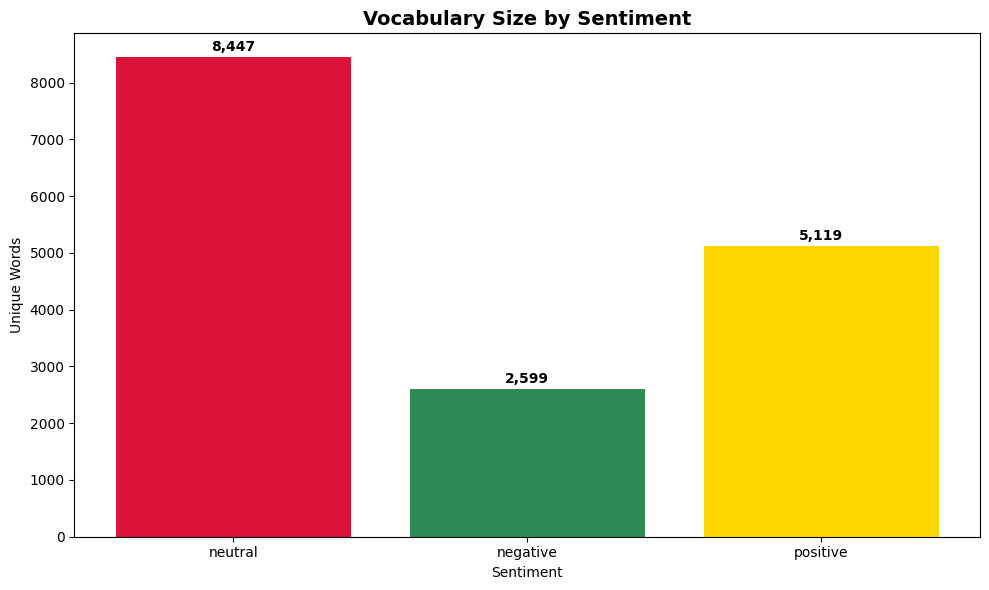

In [14]:
# Vocabulary by sentiment
sentiment_vocab = {}
sentiment_words = {}

for sentiment in df['sentiment'].unique():
    texts = df[df['sentiment'] == sentiment]['text']
    word_counts, vocab_size = get_vocabulary_stats(texts)
    sentiment_vocab[sentiment] = vocab_size
    sentiment_words[sentiment] = word_counts

print("Vocabulary size by sentiment:")
for sentiment, vocab_size in sentiment_vocab.items():
    print(f"{sentiment.capitalize()}: {vocab_size:,}")

# Visualize vocabulary sizes
plt.figure(figsize=(10, 6))
sentiments = list(sentiment_vocab.keys())
vocab_sizes = list(sentiment_vocab.values())
colors = ['#DC143C', '#2E8B57', '#FFD700']

bars = plt.bar(sentiments, vocab_sizes, color=colors)
plt.title('Vocabulary Size by Sentiment', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment')
plt.ylabel('Unique Words')

# Add value labels on bars
for bar, value in zip(bars, vocab_sizes):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
             f'{value:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## Word Frequency Analysis

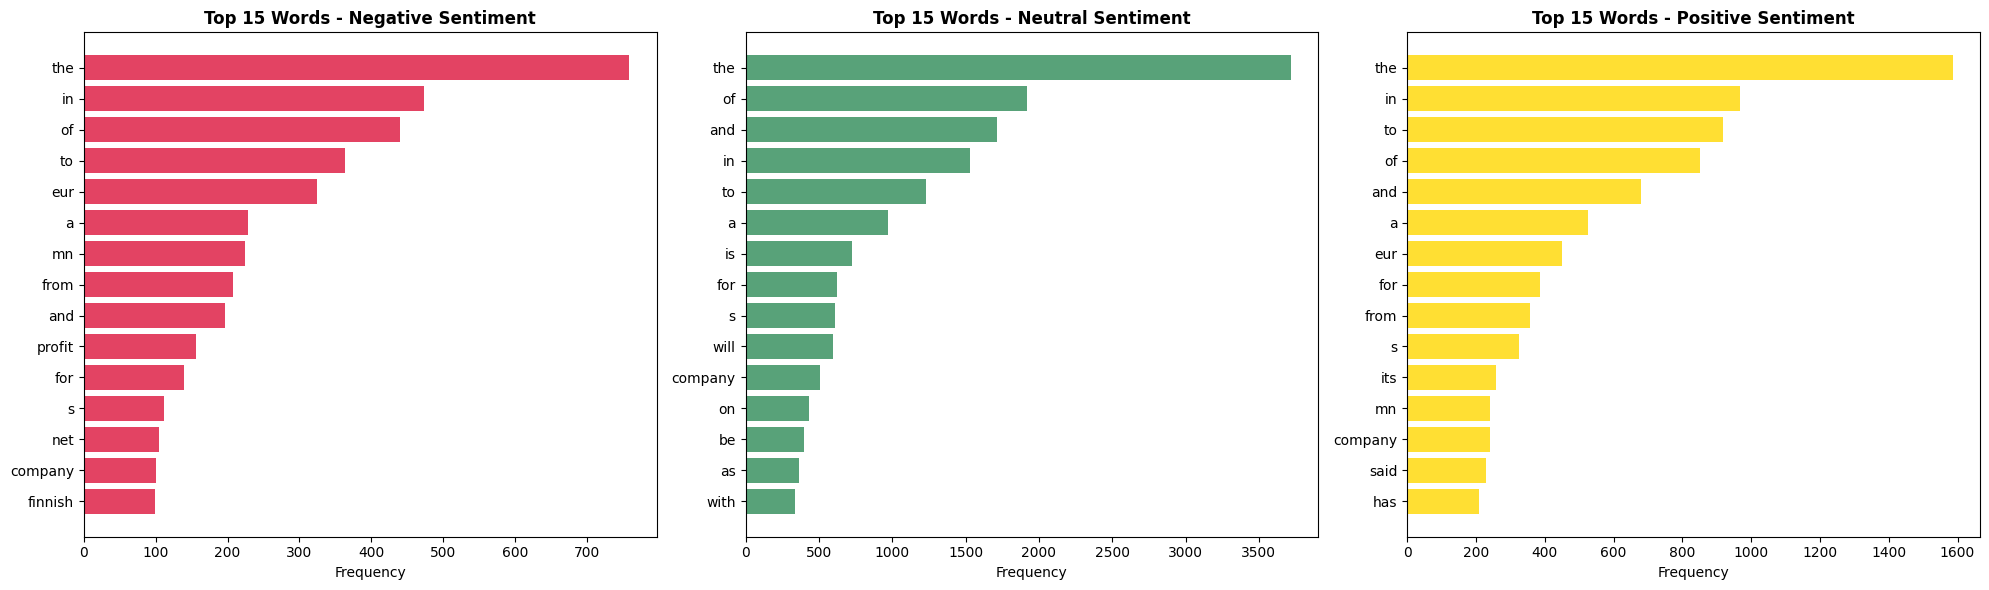

In [15]:
# Most common words by sentiment
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
sentiments = ['negative', 'neutral', 'positive']
colors = ['#DC143C', '#2E8B57', '#FFD700']

for i, sentiment in enumerate(sentiments):
    if sentiment in sentiment_words:
        top_words = dict(sentiment_words[sentiment].most_common(15))
        words = list(top_words.keys())
        counts = list(top_words.values())
        
        axes[i].barh(words, counts, color=colors[i], alpha=0.8)
        axes[i].set_title(f'Top 15 Words - {sentiment.capitalize()} Sentiment', fontweight='bold')
        axes[i].set_xlabel('Frequency')
        axes[i].invert_yaxis()

plt.tight_layout()
plt.show()

## Word Clouds

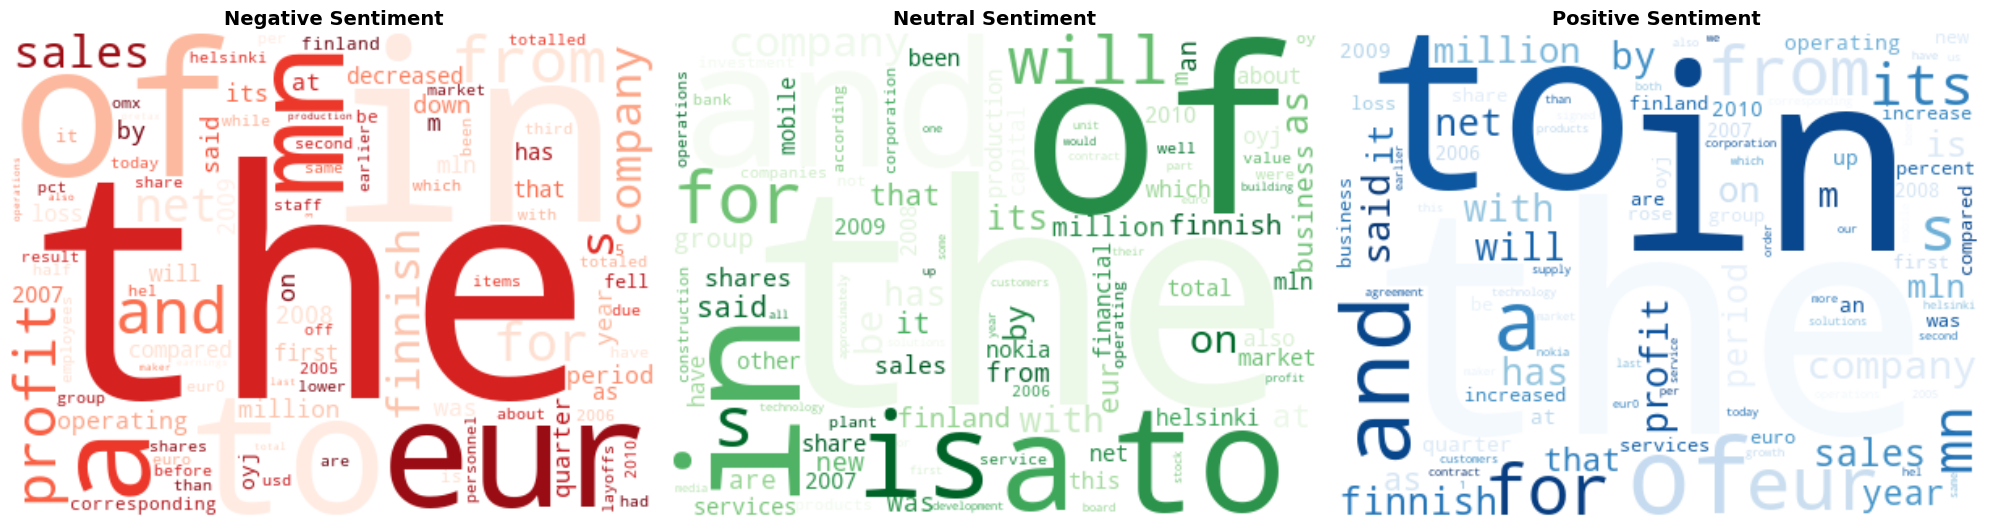

In [16]:
# Create word clouds for each sentiment
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
sentiments = ['negative', 'neutral', 'positive']
colors = ['Reds', 'Greens', 'Blues']

for i, sentiment in enumerate(sentiments):
    if sentiment in sentiment_words:
        # Create word cloud
        wordcloud = WordCloud(
            width=400, height=300, 
            background_color='white',
            colormap=colors[i],
            max_words=100,
            relative_scaling=0.5
        ).generate_from_frequencies(sentiment_words[sentiment])
        
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].set_title(f'{sentiment.capitalize()} Sentiment', fontsize=14, fontweight='bold')
        axes[i].axis('off')

plt.tight_layout()
plt.show()

## Sample Text Analysis

In [17]:
# Display sample texts for each sentiment
print("Sample Texts by Sentiment:")
print("=" * 80)

for sentiment in ['negative', 'neutral', 'positive']:
    print(f"\n{sentiment.upper()} SENTIMENT EXAMPLES:")
    print("-" * 50)
    
    samples = df[df['sentiment'] == sentiment]['text'].sample(3, random_state=42)
    
    for i, text in enumerate(samples, 1):
        print(f"\nExample {i}:")
        print(f"Length: {len(text)} characters, {len(text.split())} words")
        print(f"Text: {text}")
        print()

Sample Texts by Sentiment:

NEGATIVE SENTIMENT EXAMPLES:
--------------------------------------------------

Example 1:
Length: 150 characters, 26 words
Text: The company decided at the end of 2008 to temporarily shut down its ammonia plant in Billingham and extend the maintenance period at its Ince facility


Example 2:
Length: 143 characters, 26 words
Text: Nokia shares hit 1321 euros on Friday down 50 percent from the start of the year in part because of the slow introduction of touchscreen models


Example 3:
Length: 256 characters, 41 words
Text: The steelmaker said that the drop in profit was explained by the continuing economic uncertainty mixed with the current drought in bank lending resulting in a decline in demand for its products as customers find it increasingly difficult to fund operations


NEUTRAL SENTIMENT EXAMPLES:
--------------------------------------------------

Example 1:
Length: 141 characters, 22 words
Text: Glaston s own glass processing unit Tamglass Glass Pr

## Financial Domain Keywords Analysis

Financial Keywords Frequency:
company: 852
share: 500
sales: 454
year: 451
million: 442
profit: 433
market: 345
quarter: 312
business: 292
increase: 217
loss: 161
stock: 152
financial: 140
percent: 136
investment: 132


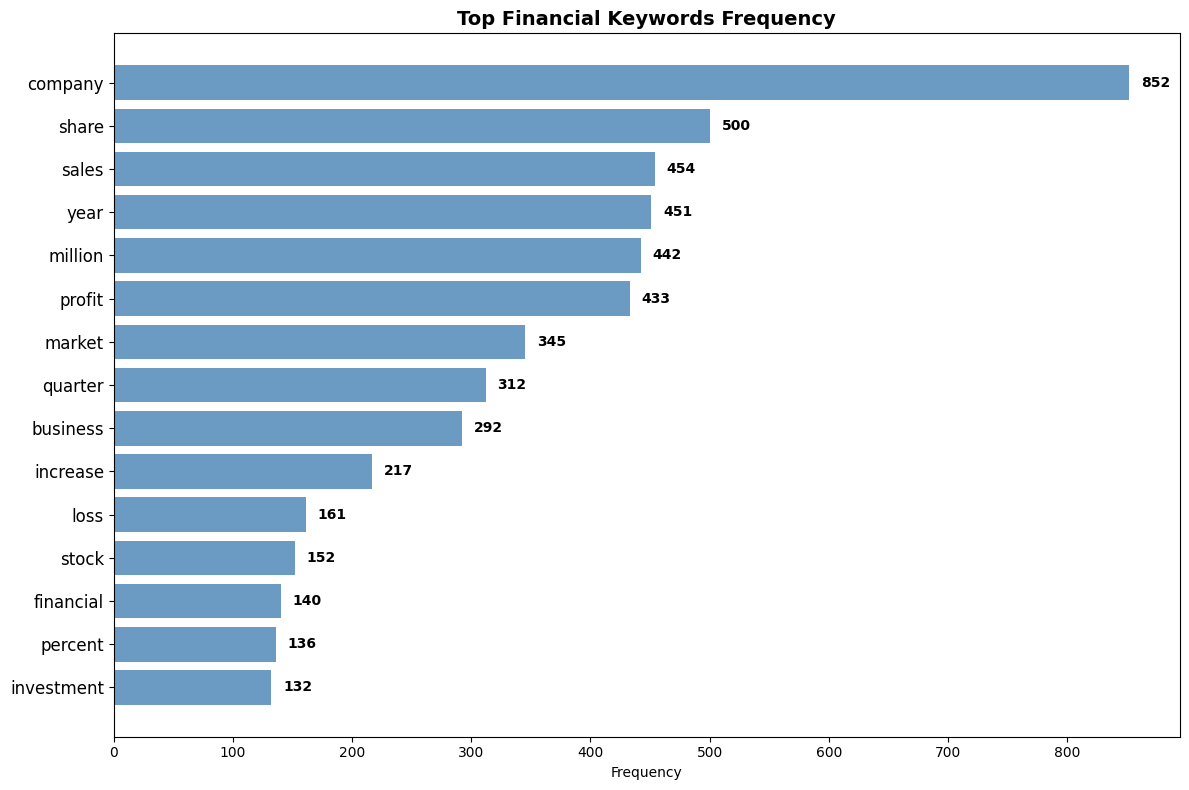

In [35]:
# Define financial keywords to analyze
financial_keywords = [
    'company', 'revenue', 'profit', 'loss', 'growth', 'sales', 'market', 
    'investment', 'stock', 'share', 'dividend', 'earnings', 'financial',
    'business', 'quarter', 'year', 'million', 'billion', 'percent',
    'increase', 'decrease', 'rise', 'fall', 'performance', 'results'
]

# Count occurrences of financial keywords
keyword_counts = {}
for keyword in financial_keywords:
    count = df['text'].str.lower().str.count(keyword).sum()
    if count > 0:
        keyword_counts[keyword] = count

# Sort by frequency
sorted_keywords = dict(sorted(keyword_counts.items(), key=lambda x: x[1], reverse=True))

print("Financial Keywords Frequency:")
for keyword, count in list(sorted_keywords.items())[:15]:
    print(f"{keyword}: {count:,}")

# Visualize top financial keywords
plt.figure(figsize=(12, 8))
top_keywords = dict(list(sorted_keywords.items())[:15])
words = list(top_keywords.keys())
counts = list(top_keywords.values())
plt.barh(words, counts, color='steelblue', alpha=0.8)
plt.title('Top Financial Keywords Frequency', fontsize=14, fontweight='bold')
plt.xlabel('Frequency')
plt.yticks(rotation=0, fontsize=12)
plt.gca().invert_yaxis()

# Add value labels
for i, (word, count) in enumerate(top_keywords.items()):
    plt.text(count + 10, i, f'{count:,}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

## Sentiment Keywords Analysis

Sentiment Indicator Analysis:
  sentiment  positive_indicators  negative_indicators  positive_per_text  \
0   neutral                  154                  125           0.053865   
1  negative                   37                  254           0.061360   
2  positive                  358                  102           0.262849   

   negative_per_text  total_texts  
0           0.043722         2859  
1           0.421227          603  
2           0.074890         1362  


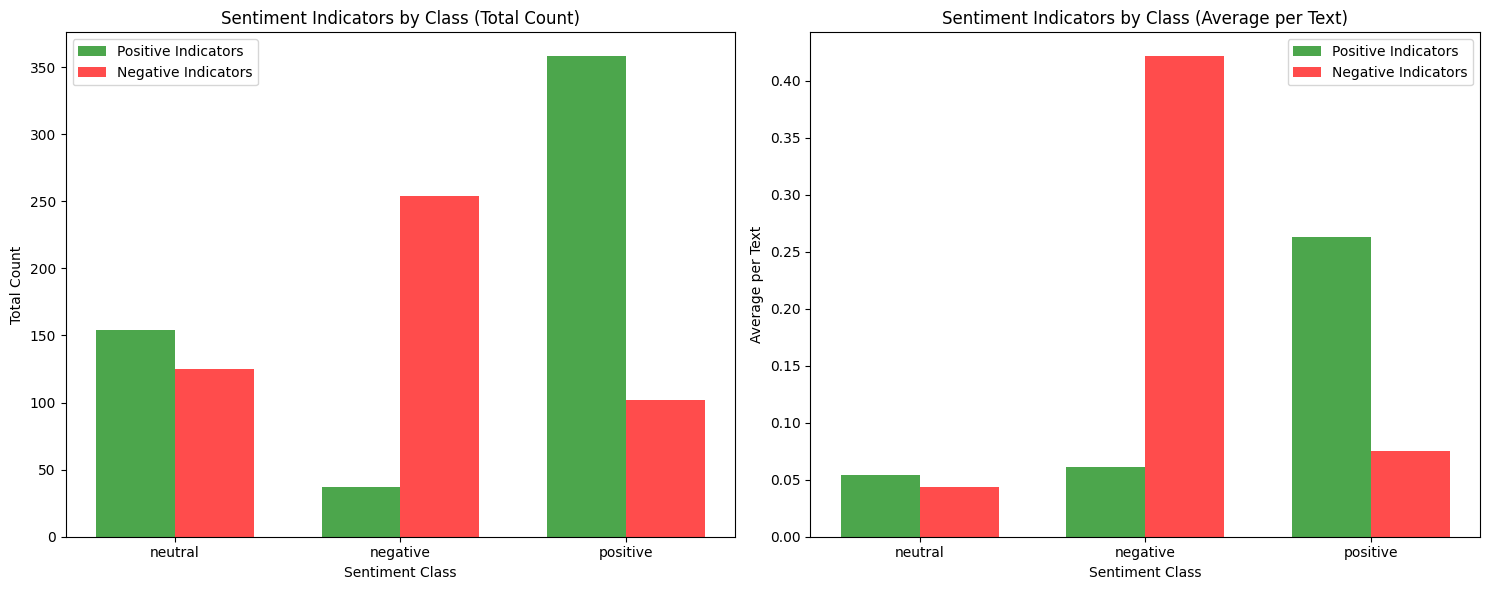

In [19]:
# Analyze sentiment-indicating words
positive_indicators = ['good', 'great', 'excellent', 'strong', 'growth', 'increase', 
                      'improvement', 'success', 'positive', 'rise', 'gain', 'benefit']
negative_indicators = ['bad', 'poor', 'weak', 'decline', 'decrease', 'loss', 'fall',
                      'negative', 'problem', 'issue', 'concern', 'risk', 'drop']

def count_indicators(texts, indicators):
    """Count sentiment indicator words in texts."""
    total_count = 0
    for text in texts:
        text_lower = text.lower()
        for indicator in indicators:
            total_count += text_lower.count(indicator)
    return total_count

# Count indicators by sentiment class
indicator_analysis = []
for sentiment in df['sentiment'].unique():
    texts = df[df['sentiment'] == sentiment]['text']
    pos_count = count_indicators(texts, positive_indicators)
    neg_count = count_indicators(texts, negative_indicators)
    total_texts = len(texts)
    
    indicator_analysis.append({
        'sentiment': sentiment,
        'positive_indicators': pos_count,
        'negative_indicators': neg_count,
        'positive_per_text': pos_count / total_texts,
        'negative_per_text': neg_count / total_texts,
        'total_texts': total_texts
    })

indicator_df = pd.DataFrame(indicator_analysis)
print("Sentiment Indicator Analysis:")
print(indicator_df)

# Visualize sentiment indicators
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Total counts
x = np.arange(len(indicator_df))
width = 0.35

ax1.bar(x - width/2, indicator_df['positive_indicators'], width, label='Positive Indicators', color='green', alpha=0.7)
ax1.bar(x + width/2, indicator_df['negative_indicators'], width, label='Negative Indicators', color='red', alpha=0.7)
ax1.set_xlabel('Sentiment Class')
ax1.set_ylabel('Total Count')
ax1.set_title('Sentiment Indicators by Class (Total Count)')
ax1.set_xticks(x)
ax1.set_xticklabels(indicator_df['sentiment'])
ax1.legend()

# Per text averages
ax2.bar(x - width/2, indicator_df['positive_per_text'], width, label='Positive Indicators', color='green', alpha=0.7)
ax2.bar(x + width/2, indicator_df['negative_per_text'], width, label='Negative Indicators', color='red', alpha=0.7)
ax2.set_xlabel('Sentiment Class')
ax2.set_ylabel('Average per Text')
ax2.set_title('Sentiment Indicators by Class (Average per Text)')
ax2.set_xticks(x)
ax2.set_xticklabels(indicator_df['sentiment'])
ax2.legend()

plt.tight_layout()
plt.show()

## Data Quality Assessment

In [20]:
# Data quality checks
print("Data Quality Assessment:")
print("=" * 50)

# Check for empty or very short texts
empty_texts = df[df['text'].str.len() == 0]
short_texts = df[df['text'].str.len() < 10]
very_long_texts = df[df['text'].str.len() > 1000]

print(f"Empty texts: {len(empty_texts)}")
print(f"Very short texts (<10 chars): {len(short_texts)}")
print(f"Very long texts (>1000 chars): {len(very_long_texts)}")

# Check for duplicate texts
duplicate_texts = df[df.duplicated('text', keep=False)]
print(f"Duplicate texts: {len(duplicate_texts)}")

# Check sentiment label consistency
unique_sentiments = df['sentiment'].unique()
print(f"\nUnique sentiment labels: {unique_sentiments}")

# Check for potential encoding issues
special_chars = df['text'].str.contains(r'[^\w\s.,!?;:()\-\'"]+', regex=True).sum()
print(f"Texts with special characters: {special_chars}")

# Display examples of potential issues
if len(short_texts) > 0:
    print("\nExamples of very short texts:")
    for i, text in enumerate(short_texts['text'].head(3)):
        print(f"{i+1}. '{text}'")

if len(duplicate_texts) > 0:
    print("\nExamples of duplicate texts:")
    duplicates = duplicate_texts.groupby('text').size().head(3)
    for text, count in duplicates.items():
        print(f"Text appears {count} times: '{text[:100]}...'")

Data Quality Assessment:
Empty texts: 0
Very short texts (<10 chars): 0
Very long texts (>1000 chars): 0
Duplicate texts: 20

Unique sentiment labels: ['neutral' 'negative' 'positive']
Texts with special characters: 84

Examples of duplicate texts:
Text appears 2 times: 'Ahlstrom s share is quoted on the NASDAQ OMX Helsinki...'
Text appears 2 times: 'Glaston s wellknown brands are Bavelloni in preprocessing machines and tools Tamglass and Uniglass i...'
Text appears 2 times: 'Proha Plc Euronext 7327 announced today 19 May that its fullyowned subsidiary Safran Software Soluti...'


## Train/Validation/Test Split Analysis

In [21]:
# Load and analyze the splits
splits = {}
split_files = {
    'train': '../data/financial_news/all-data_train.csv',
    'validation': '../data/financial_news/all-data_val.csv',
    'test': '../data/financial_news/all-data_test.csv'
}

for split_name, file_path in split_files.items():
    try:
        split_df = pd.read_csv(file_path)
        splits[split_name] = split_df
        print(f"{split_name.capitalize()} set: {len(split_df):,} samples")
    except FileNotFoundError:
        print(f"{split_name.capitalize()} file not found: {file_path}")

if splits:
    # Analyze sentiment distribution across splits
    fig, axes = plt.subplots(1, len(splits), figsize=(15, 5))
    if len(splits) == 1:
        axes = [axes]
    
    for i, (split_name, split_df) in enumerate(splits.items()):
        sentiment_dist = split_df['sentiment'].value_counts()
        sentiment_dist.plot(kind='bar', ax=axes[i], color=['#DC143C', '#2E8B57', '#FFD700'])
        axes[i].set_title(f'{split_name.capitalize()} Set\nSentiment Distribution')
        axes[i].set_xlabel('Sentiment')
        axes[i].set_ylabel('Count')
        axes[i].tick_params(axis='x', rotation=45)
        
        # Add percentage labels
        total = len(split_df)
        for j, v in enumerate(sentiment_dist.values):
            pct = (v / total) * 100
            axes[i].text(j, v + 10, f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Create summary table
    split_summary = []
    for split_name, split_df in splits.items():
        sentiment_counts = split_df['sentiment'].value_counts()
        summary = {'Split': split_name.capitalize(), 'Total': len(split_df)}
        for sentiment in ['negative', 'neutral', 'positive']:
            count = sentiment_counts.get(sentiment, 0)
            pct = (count / len(split_df)) * 100
            summary[f'{sentiment.capitalize()}'] = f'{count} ({pct:.1f}%)'
        split_summary.append(summary)
    
    summary_df = pd.DataFrame(split_summary)
    print("\nSplit Summary:")
    print(summary_df.to_string(index=False))

Train file not found: ../data/financial_news/all-data_train.csv
Validation file not found: ../data/financial_news/all-data_val.csv
Test file not found: ../data/financial_news/all-data_test.csv
